The code in here is a variation of the code in `survey-tools.ipynb` which I have adapted to differentiate between different age groups or occupational groups in my survey data. I have made some changes so that different sheets (containing the same questions in the same structure, of course) can be loaded from one .xlsx to represent the different group data. The graphs are then designed to show each of the different data points and make them comparable.

---
        Imports
---

In [16]:
import re
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
         Load the data
---

In [17]:
# I have added three new sheets to the original Excel file: unter 30, 30 bis 49, über 50 which are the results of the survey for the age groups.
dfs = {}
dfs["gesamt"] = pd.read_excel("statistic-survey-con.xlsx", sheet_name="gesamt")
dfs["unter 30"] = pd.read_excel("statistic-survey-con.xlsx", sheet_name="unter 30")
dfs["30 bis 49"] = pd.read_excel("statistic-survey-con.xlsx", sheet_name="30 bis 49")
dfs["über 50"] = pd.read_excel("statistic-survey-con.xlsx", sheet_name="über 50")

# Blocks with question starts with "Zusammenfassung für"
df_question_summary_rows = {}
for key, df in dfs.items():
  df_question_summary_rows[key] = df[df.iloc[:, 0].str.startswith("Zusammenfassung für", na=False)]
  

---
        Calculate acceptance scores
---

Acceptance scores are calculated using weights for the Likert scale (as shown directly below). The acceptance score is then calculated as the arithmetic mean according to "Likert, R. (1932). A technique for the measurement of attitudes. Archives of Psychology, 22 140, 55".

In [18]:
# Likert scale weights
likert_weights = {
    "Stimme gar nicht zu (AO01)": 1,    # Strongly Disagree
    "Stimme eher nicht zu (AO02)": 2,   # Disagree
    "Neutral (AO03)": 3,                # Neutral
    "Stimme eher zu (AO04)": 4,         # Agree
    "Stimme voll zu (AO05)": 5,         # Strongly Agree
    # "Keine Antwort" is excluded
}

df_question_data = {}
df_acceptance_scores = {}

# in difference to the original script at "./survey-tools.ipynb" this one has dfs for each age group 
for key, question_summary_rows in df_question_summary_rows.items():
    question_data = {}
    # Iterate through each question summary row to extract the question and its answers
    for index, row in question_summary_rows.iterrows():
        question_name = row.iloc[0]

        # Only the questions for the meta-requirements are questions on likert scale
        if question_name.startswith("Zusammenfassung für MA"):
            answer_rows = dfs[key].iloc[index+3:index+9]
        else:
            # The other questions gather meta information and could be skipped
            next_empty_row = dfs[key].iloc[index+3:].isna().all(axis=1).idxmax()
            answer_rows = dfs[key].iloc[index+3:next_empty_row]
            
        question_data[question_name] = answer_rows

    acceptance_scores = {}

    for question, answers in question_data.items():
        # remove non meta-requirements questions
        filtered_answers = answers[answers.iloc[:, 0].isin(likert_weights.keys())]

        # Calculate the weighted sum of responses
        weighted_sum = sum(filtered_answers.iloc[:, 1] * filtered_answers.iloc[:, 0].map(likert_weights))

        total_responses = filtered_answers.iloc[:, 1].sum()

        # Calculate the acceptance score as in
        #   Likert, R. (1932). A technique for the measurement of attitudes. Archives of Psychology, 22 140, 55.
        if total_responses > 0:
            acceptance_score = weighted_sum / total_responses
        else:
            acceptance_score = None  

        acceptance_scores[question] = acceptance_score
    
    df_acceptance_scores[key] = acceptance_scores

df_acceptance_scores

{'gesamt': {'Zusammenfassung für MetaBauJaNein': None,
  'Zusammenfassung für MetaAlter': None,
  'Zusammenfassung für MetaJobbezeichnung': None,
  'Zusammenfassung für MetaJobbereich': None,
  'Zusammenfassung für MA1(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
  'Zusammenfassung für MA2(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
  'Zusammenfassung für MA3(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
  'Zusammenfassung für MA4(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.142857142857143,
  'Zusammenfassung für MA5(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
  'Zusammenfassung für MA6(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.095238095238095,
  'Zusammenfassung für MA7(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.333333333333333,
  'Zusammenfassung für MA8(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.809523809523809,
  'Zusammenfassung für MA9(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
  'Zusammenfassung für MA

In [19]:
questions_filtered = {}
scores_filtered = {}

for key, acceptance_scores in df_acceptance_scores.items():
    # Filter and extract the meta-requirements questions (starting with "MA")
    filtered_scores = {q: score for q, score in acceptance_scores.items() if score is not None}
    filtered_questions = {re.findall("MA[0-9]+", q)[0]: score for q, score in filtered_scores.items() if re.search("MA[0-9]+", q)}

    questions_filtered[key] = list(filtered_questions.keys())
    scores_filtered[key] = list(filtered_questions.values())

    average_score = sum(scores_filtered[key]) / len(scores_filtered[key])
    sorted_scores = sorted(scores_filtered[key])
    length = len(sorted_scores)

    if length % 2 == 1:
        median = sorted_scores[length // 2]
    else:
        median = (sorted_scores[length // 2 - 1] + sorted_scores[length // 2]) / 2

    print(f"Median score for {key}: {median}")
    print(f"Average score for {key}: {average_score}")


Median score for gesamt: 4.404761904761905
Average score for gesamt: 4.341269841269841
Median score for unter 30: 4.666666666666667
Average score for unter 30: 4.569444444444444
Median score for 30 bis 49: 4.666666666666667
Average score for 30 bis 49: 4.472222222222223
Median score for über 50: 4.25
Average score for über 50: 4.244047619047619


---
        Plot: Individual acceptance scores
---

This is different from the script in `./survey-tools.ipynb` because it also breaks down each question score into how the age groups answered it. This requires some additional logic, especially for offsetting the bars.

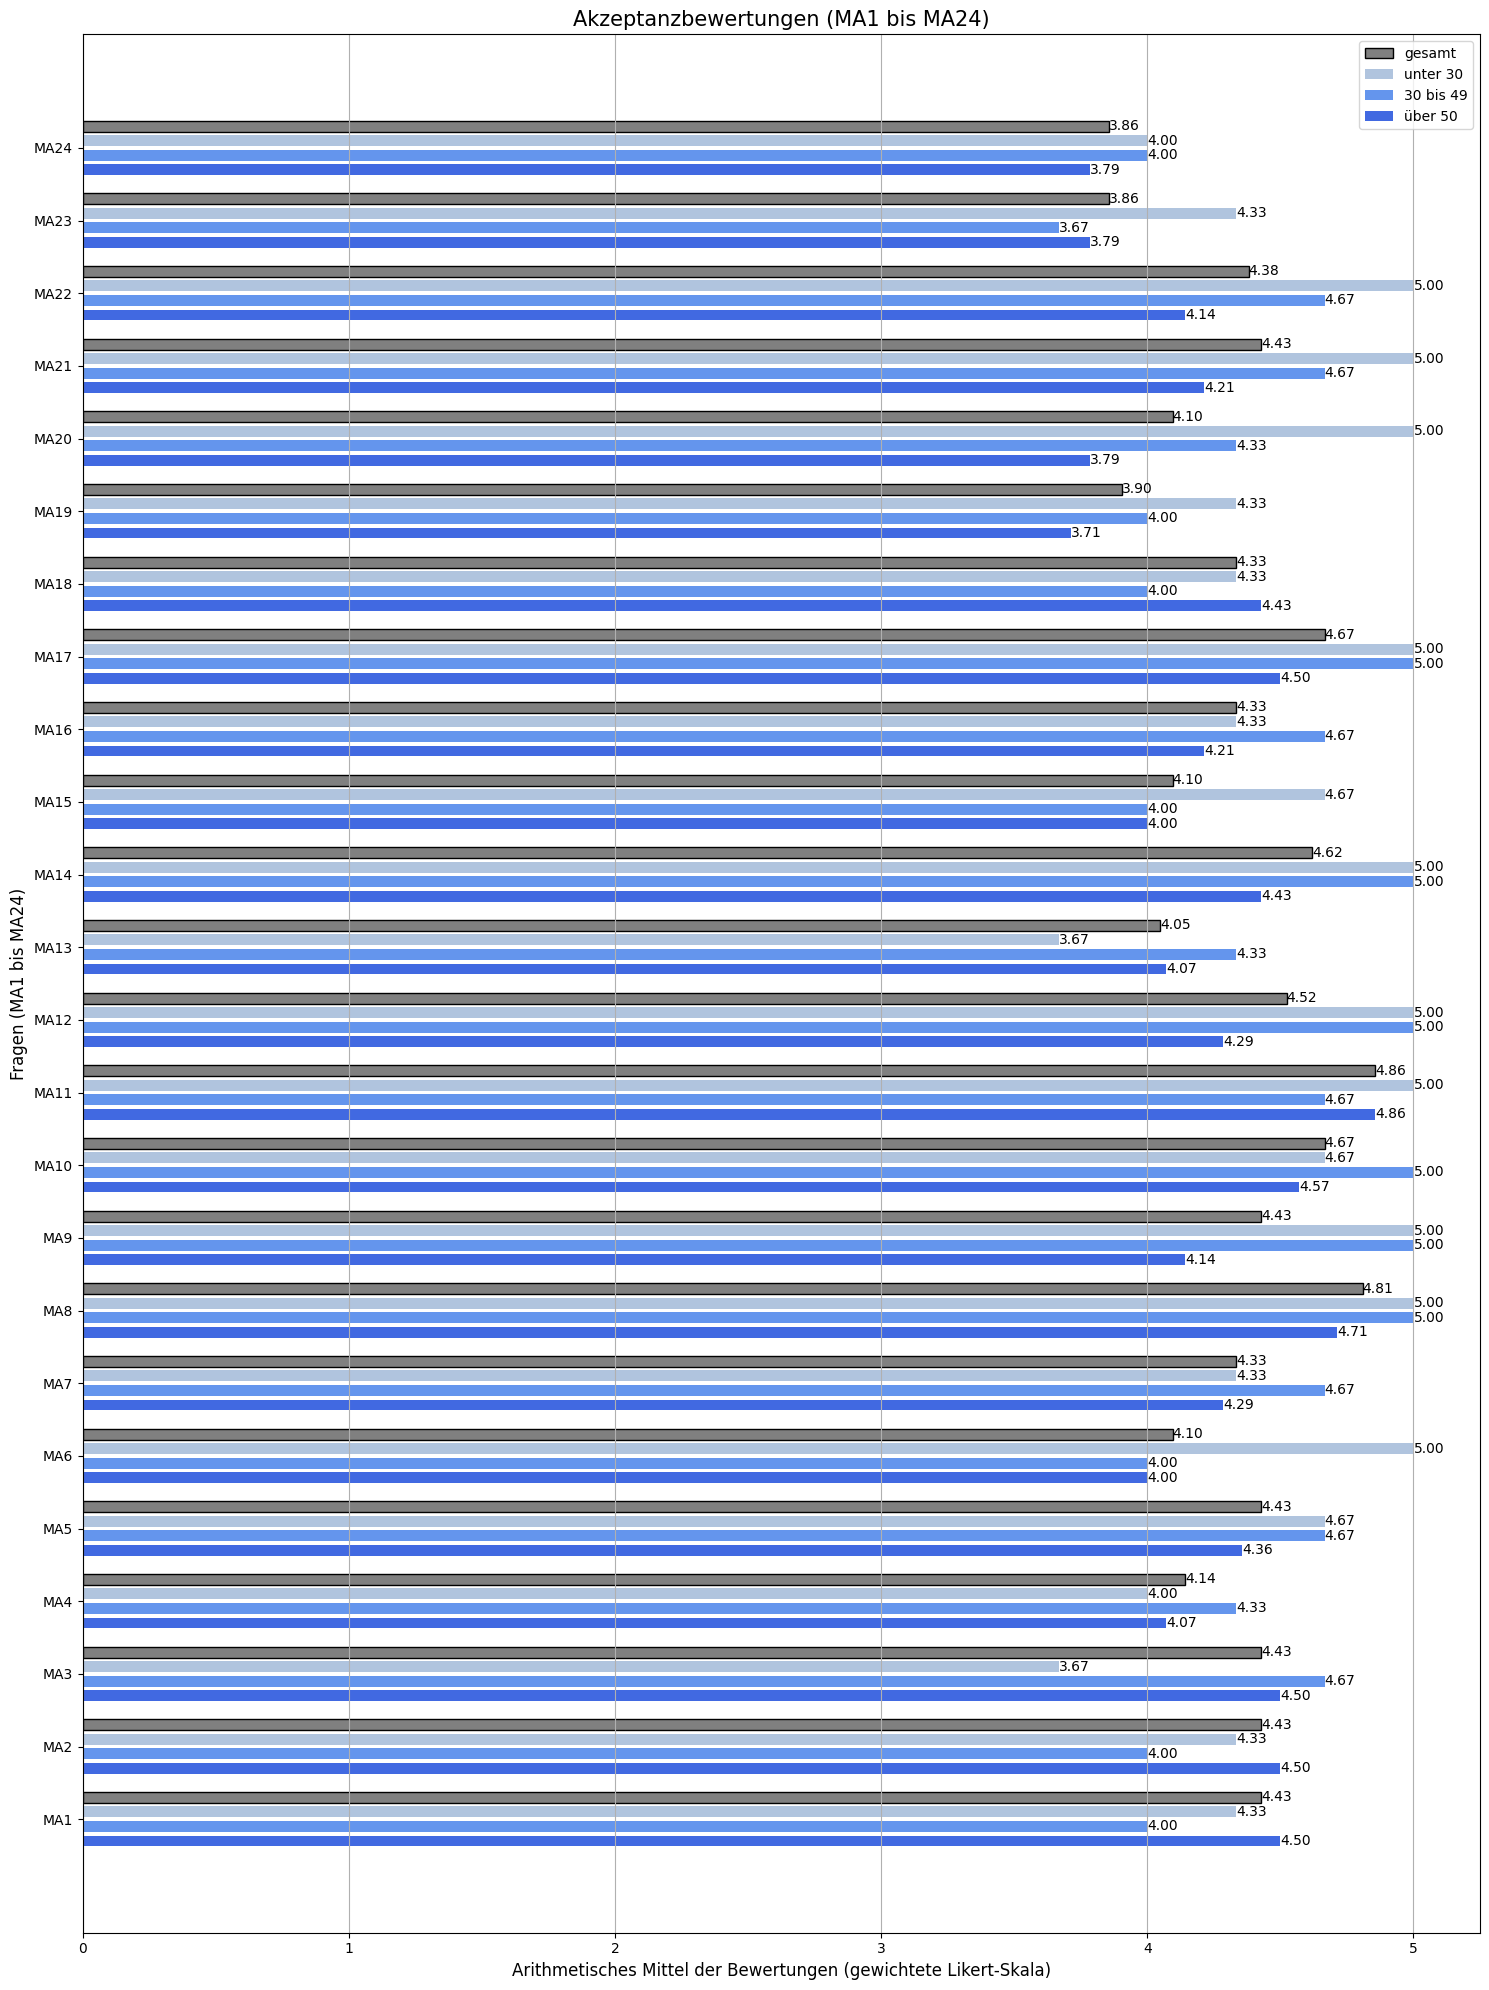

In [20]:
keys = np.flip(list(questions_filtered.keys()))  # flip the keys so that "gesamt" is on top
num_keys = len(keys)
total_width = 0.6  # 0.4 is added padding between the different MAs

plt.figure(figsize=(15, 20))
ax = plt.gca()

individual_width = total_width / num_keys
offsets = np.linspace(-total_width / 2, total_width / 2, num_keys)
colors = ["royalblue", "cornflowerblue", "lightsteelblue", "grey"]

for i, key in enumerate(keys):
    positions = np.arange(len(questions_filtered[key])) + offsets[i]
    
    if key == "gesamt": # black borders to the bars of the "gesamt" age group to differentiate them
        bars = ax.barh(positions, scores_filtered[key], height=individual_width, color=colors[i % len(colors)], label=key, edgecolor = "black")
    else:
        bars = ax.barh(positions, scores_filtered[key], height=individual_width, color=colors[i % len(colors)], label=key)
    
    # Plot values on the bars
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f"{bar.get_width():.2f}", 
                va="center", ha="left", color="black", fontsize=10)

plt.xlabel("Arithmetisches Mittel der Bewertungen (gewichtete Likert-Skala)", fontsize=12)
plt.ylabel("Fragen (MA1 bis MA24)", fontsize=12)
plt.title("Akzeptanzbewertungen (MA1 bis MA24)", fontsize=15)
ax.set_yticks(np.arange(len(questions_filtered[keys[0]])))
ax.set_yticklabels(questions_filtered[keys[0]])
plt.grid(axis="x")

# Reversed legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

plt.tight_layout()
today = date.today().strftime("%Y-%m-%d")
plot_name = f"acceptance_plot_age_groups-{today}"
plt.savefig(f"{plot_name}.pdf", format="pdf")


---
        Plot: Overall distribution box plot
---

I also wanted to get an overview of how the overall level of acceptance changes between age groups. As expected, acceptance of new tools decreases with age.

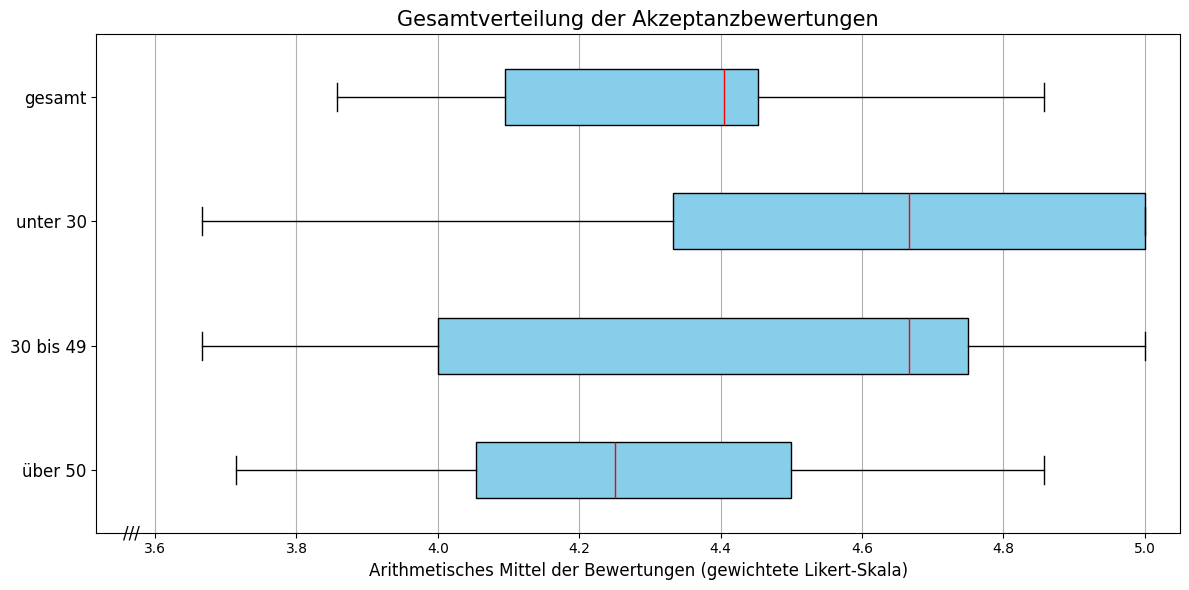

In [21]:
plt.figure(figsize=(12, 6))

# Create a box plot for each key
boxplots = [scores_filtered[key] for key in keys]
plt.boxplot(boxplots, vert=False, patch_artist=True,
            medianprops=dict(color="red"), boxprops=dict(facecolor="skyblue"),
            whiskerprops=dict(color="black"), capprops=dict(color="black"),
            flierprops=dict(marker="o", color="red", markersize=5))

plt.title("Gesamtverteilung der Akzeptanzbewertungen", fontsize=15)
plt.yticks(np.arange(1, len(keys) + 1), keys, fontsize=12)
plt.xlabel("Arithmetisches Mittel der Bewertungen (gewichtete Likert-Skala)", fontsize=12)
plt.grid(axis="x")
all_scores = [score for scores_list in scores_filtered.values() for score in scores_list]
plt.xlim(min(all_scores) - 0.15, max(all_scores) + 0.05)

# custom break in x-axis
plt.text((min(all_scores) - 0.1), 0.42, "///", 
         horizontalalignment="center", verticalalignment="bottom", fontsize=12, color="black")

plt.tight_layout()
today = date.today().strftime("%Y-%m-%d")
plot_name = f"acceptance_boxplot_age_groups-{today}"
plt.savefig(f"{plot_name}.pdf", format="pdf")